In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm
from matplotlib.pyplot import figure
from xml.etree import ElementTree as et
from xml.dom import minidom
from scipy.spatial.transform import Rotation as R
import matplotlib.colors as colors
%matplotlib inline

In [2]:
def quaternion_from_vector(vector_2d):
    vec1=np.array([1, 0, 0])
    vec2=np.array([vector_2d[0], vector_2d[1], 0])
    
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    
    r = R.align_vectors(vec2, vec1)
    return r[0].as_quat()

def read_path_x_y_yaw_s(file_name):
    f = open(file_name)
    success = False
    xs = []
    ys = []
    yaws = []
    for line in f:
        if line.split()[0] == "False":
            success = False
            break
        if line.split()[0] == "True":
            success = True
            break
        
        x, y, yaw = list(map(float, line.split()))
        xs.append(x)
        ys.append(y)
        yaws.append(yaw)
        
    return xs, ys, yaws, success
        
def get_height(x, y, resolution, height_map):
    len_x = height_map.shape[0] * resolution
    len_y = height_map.shape[1] * resolution
    i, j = get_ij(x, y, resolution,len_x, len_y)
    try:
        h = height_map[i, j]
    except:
        print(i, j)
        h = 0
    return h

def get_ij(x, y, resolution, len_x, len_y):
    i = int((len_x/2 - x) / resolution)
    j = int((len_y/2 - y) / resolution)
    return i, j
    

def convert_path_to_x_y_z(xs, ys, resolution, height_map):
    steps = len(xs)
    x = np.array(xs)
    y = np.array(ys)
    z = np.array([get_height(x[i], y[i], resolution, height_map) for i in range(len(xs))])
    
    path = np.vstack((x, y, z))
    path = np.transpose(path)
    
    return path

def draw_map_2d(height_map, resolution):
    min_x = -height_map.shape[0]/2 * resolution
    max_x = height_map.shape[0]/2  * resolution
    min_y = -height_map.shape[1]/2  * resolution
    max_y = height_map.shape[1]/2  * resolution

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)


    delta = 0.1
    x = np.arange(-3.0, 4.001, delta)
    y = np.arange(-4.0, 3.001, delta)
    X, Y = np.meshgrid(x, y)
    Z1 = np.exp(-X**2 - Y**2)
    Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
    Z = (0.9*Z1 - 0.5*Z2) * 2
    
    cmap = plt.cm.get_cmap('RdYlBu')
    cmap = cmap.reversed()
    
    divnorm = colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=2.5)
    
    p = plt.imshow(height_map, cmap=cmap, extent=[max_y, min_y, min_x, max_x],  norm = divnorm)
    cbar = plt.colorbar(p)
    cbar.set_ticks([-0.1, 0, 0.5, 1, 1.5, 2, 2.5])
    
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    return fig, ax
    

    
    

# Experimental Maps

## Map 1

In [3]:

map_size_1 = (200, 200) # pixels
map_1 = np.zeros(map_size_1)
resolution = 0.05 # meters

center = (100, 100) # pixels
r_big = 70 # pixels
r_small = 30 # pixels
top_height = 2.5 # meters

full_height = r_big/(r_big - r_small) * top_height

for i in range(map_size_1[0]):
    for j in range(map_size_1[1]):
        if ((i - center[0]) ** 2 + (j - center[1]) ** 2 <= r_big ** 2 ):
            if ((i - center[0]) ** 2 + (j - center[1]) ** 2 <= r_small ** 2 ):
                map_1[i, j] = top_height
            else:
                v = np.array([(i - center[0]), (j - center[1])])
                dist = r_big - np.linalg.norm(v)
                map_1[i, j] = dist/r_big * full_height
            
            
min_x_1 = -map_size_1[0]/2 * resolution
max_x_1 = map_size_1[0]/2  * resolution
min_y_1 = -map_size_1[0]/2  * resolution
max_y_1 = map_size_1[0]/2  * resolution

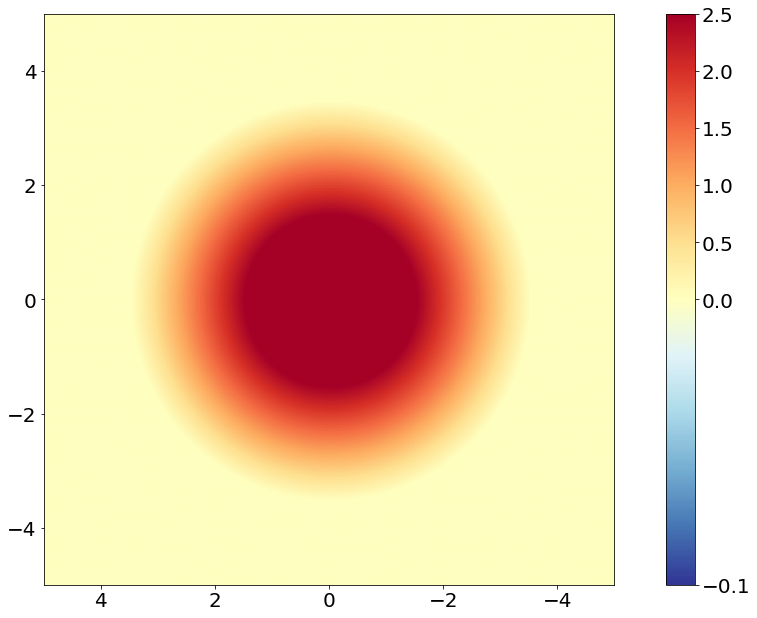

In [4]:
draw_map_2d(map_1, resolution)
# plt.savefig('map_1.png', bbox_inches='tight', dpi=300)
plt.show()

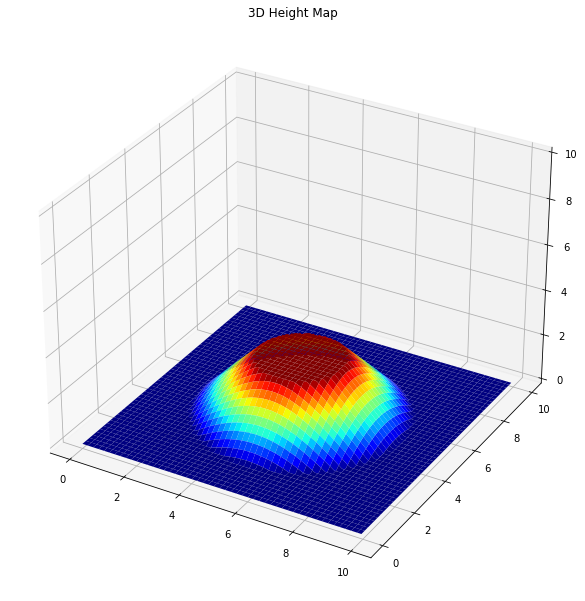

In [5]:
z = map_1
x_real = resolution * np.array(range(z.shape[0]))
y_real = resolution * np.array(range(z.shape[1]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(0, 10)

plt.title('3D Height Map')
plt.show()


## Map 2

In [6]:
map_size_2 = (240, 160) # pixels
map_2 = np.zeros(map_size_2) 
resolution = 0.05 # meters

box_height = 0.5 # meters
box_len = 100 # pixels

center_j = map_size_2[1] // 2 

ramp_len = 100 # pixels
box_width = 80 # pixels

map_2[:box_len, :] = box_height

for i in range(box_len, box_len + ramp_len):
    for j in range(center_j - box_width // 2,  center_j + box_width // 2):
        map_2[i, j] = -(i - box_len - ramp_len) / ramp_len * box_height


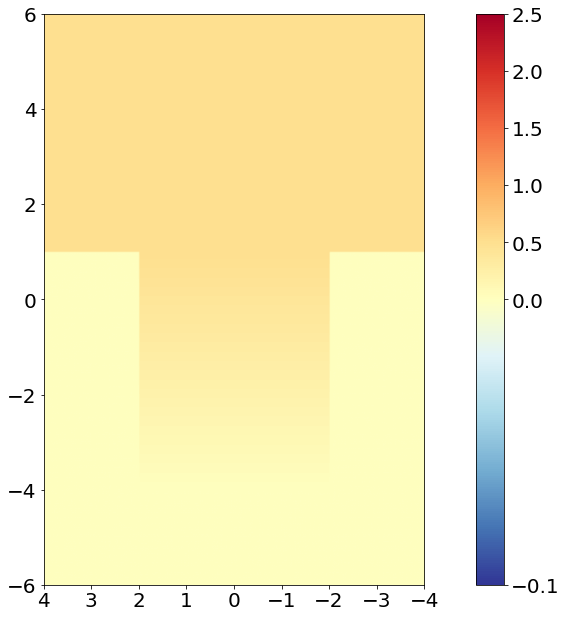

In [7]:
draw_map_2d(map_2, resolution)
# plt.savefig('map_2.png', bbox_inches='tight', dpi=300)
plt.show()

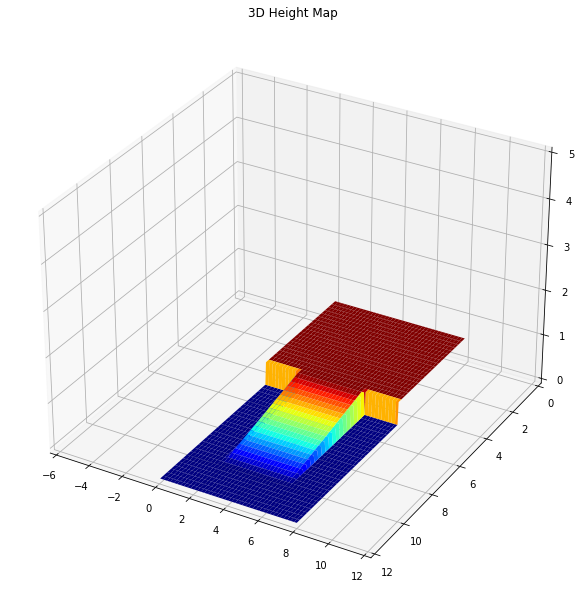

In [8]:
z = map_2
x_real = resolution * np.array(range(z.shape[1]))
y_real = resolution * np.array(range(z.shape[0]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(0,5)
ax.set_ylim(z.shape[0] * resolution ,0)
ax.set_xlim(-z.shape[0] * resolution/2, z.shape[0] * resolution)

plt.title('3D Height Map')
plt.show()

## Карта 3

In [9]:
map_size_3 = (240, 100) # pixels
map_3 = np.zeros(map_size_3)
resolution = 0.05 # meters

hole_center = (90, 20) # pixels
hole_half_size = (5, 20) # pixels
hole_depth = 0.05 # meters

hole_center_2 = (150, 80) # pixels
hole_half_size_2 = (5, 20) # pixels
hole_depth_2 = 0.05 # meters

map_3[hole_center[0] - hole_half_size[0]:hole_center[0] + hole_half_size[0], 
      hole_center[1] - hole_half_size[1]:hole_center[1] + hole_half_size[1]] = -hole_depth

map_3[hole_center_2[0] - hole_half_size_2[0]:hole_center_2[0] + hole_half_size_2[0], 
      hole_center_2[1] - hole_half_size_2[1]:hole_center_2[1] + hole_half_size_2[1]] = -hole_depth_2


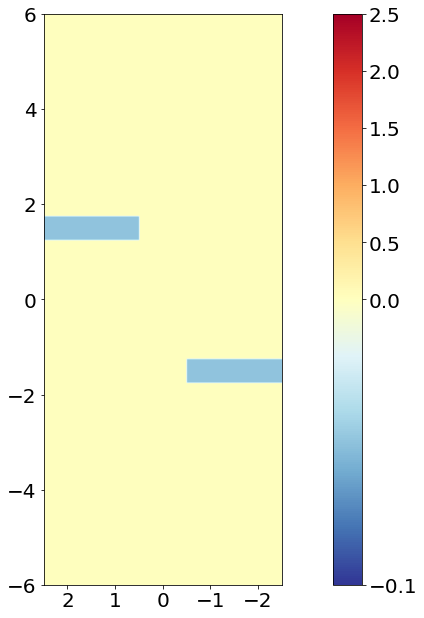

In [10]:
draw_map_2d(map_3, resolution)
# plt.savefig('map_3.png', bbox_inches='tight', dpi=300)
plt.show()

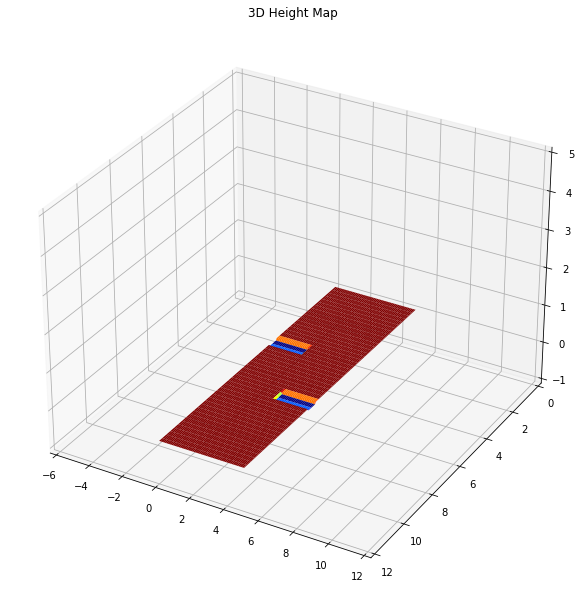

In [11]:
z = map_3
x_real = resolution * np.array(range(z.shape[1]))
y_real = resolution * np.array(range(z.shape[0]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(-1,5)
ax.set_ylim(z.shape[0] * resolution ,0)
ax.set_xlim(-z.shape[0] * resolution/2, z.shape[0] * resolution)

plt.title('3D Height Map')
plt.show()

# Paths evaluation


- Path length $L$
- Simulation time of path $T$
- Max height difference of path steps $H$ (not used)
- Max slope $S$ and roughness $R$ of agent footprint (not used)

## Max height difference of path steps (not used)

$$
H(\pi) = \max_{i = 0...n-2}{\Delta z(\pi_i, \pi_{i+1})}
$$



 - $\pi$ - obtained path
 - $n$ - number of steps in path

In [12]:
def max_height_diff(path):
    max_dz = 0.0 
    for i in range(len(path)-1):
        z_prev = path[i][2]
        z = path[i+1][2]
        dz = abs(z_prev - z)
        if dz > max_dz:
            max_dz = dz
        
    return max_dz

## Path length


$$
L(\pi) = \sum_{i = 0}^{n-1}{dist(\pi_i, \pi_{i+1})}
$$

$$
dist(a, b) = \sqrt{(a_x - b_x)^2 + (a_y - b_y)^2 + (a_z - b_z)^2}
$$

 - $\pi$ - obtained path
 - $n$ - number of steps in path

In [13]:
def path_len(path):
    res = 0.0
    for i in range(len(path)-1):
        x_prev = path[i][0]
        y_prev = path[i][1]
        z_prev = path[i][2]
        x = path[i+1][0]
        y = path[i+1][1]
        z = path[i+1][2]
        p_prev = np.array([x_prev, y_prev, z_prev])
        p = np.array([x, y, z])
        dist = np.linalg.norm(p - p_prev)
        res += dist
    return res

## Simulation time of path $T$


$$
T(\pi) = n * \Delta t
$$

 - $\pi$ - obtained path
 - $n$ - number of steps in path
 - $\Delta t$ - duration of single step

In [14]:
def sim_time(path, dt):
    return path.shape[0] * dt

## Max slope and roughness of agent footprint (not used)

One of methods, that was used in MPPI

$$a_i, b_i, c_i = LeastSquareSolution(\{ (x_j, y_j, z_j) \in \mathcal{B}_r(\pi_i) \})$$
$$S_{slope}(\pi) = \max_{\pi_i \in \pi} \arccos(\frac{1}{\sqrt{a_i^2 + b_i^2 + 1}}(a_i, b_i, -1) \cdot (0, 0, 1))$$

$$\sigma_i = \sqrt{\frac{1}{|\mathcal{B}_r(\pi_i)|} \sum\limits_{(x_j, y_j, z_j) \in \mathcal{B}_r(\pi_i)} \frac{(a_i x_j + b_i y_j + c_i - z_j)^2}{a_i^2 + b_i^2 + 1}}$$
$$S_{rough}(\pi) = \max_{\pi_i \in \pi}  \sigma_i$$

 - $\pi$ - obtained path
 - $\pi_i$ - step $i$ in path $\pi$ 
 - $\mathcal{B}_r(\pi_i)$ - footprint of agent located in position $\pi_i$


In [15]:
def get_footprint(x, y, height_map, resolution, size):
    xs = np.linspace(x-size, x+size, 10, endpoint=True)
    ys = np.linspace(y-size, y+size, 10, endpoint=True)
    footprint = []
    
    for p_x in xs:
        for p_y in ys:
            dist = np.linalg.norm([p_x-x, p_y-y])
            if(dist < size):
                p_z = get_height(p_x, p_y, resolution, height_map)
                footprint.append((p_x, p_y, p_z))
        
    return np.array(footprint)
    

def slope_roughness_footpint(footprint):
    (rows, cols) = footprint.shape
    G = np.ones((rows, 3))
    G[:, 0] = footprint[:, 0]
    G[:, 1] = footprint[:, 1]
    Z = footprint[:, 2]
    (a, b, c), resid, rank, s = np.linalg.lstsq(G, Z)
    normal = (a, b, -1)
    nn = np.linalg.norm(normal)
    normal = normal / nn
    uni_z = np.array([0, 0, 1])
    
    rgh = math.sqrt(resid / rows)
    slp = math.acos(abs(np.dot(normal, uni_z)))
    return (slp, rgh)




def max_slope_roughness(height_map, path, size, resolution):
    slp = []
    rgh = []
    for point in path:
        s,r = slope_roughness_footpint(get_footprint(point[0], point[1], height_map, resolution, size))
        slp.append(s)
        rgh.append(r)
    return np.max(slp), np.max(rgh)
                    
                    
                                 
                    

# Generation of XML files

In [16]:
def prettify(elem):
    rough_string = et.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [17]:
def map_xml_generator(height_map, resolution, file_path):

    root = et.Element('map')
    
    width = height_map.shape[1]
    height = height_map.shape[0]
    
    res = et.SubElement(root, 'resolution')
    res.text = str(resolution)
    
    w = et.SubElement(root, 'width')
    w.text = str(width)
    
    h = et.SubElement(root, 'height')
    h.text = str(height)
    
    grid = et.SubElement(root, 'grid')
    
    for row in height_map:
        row_tag = et.SubElement(grid, 'row')
        row_tag.text = ' '.join(map(str, row))
        
    map_file = open(file_path, "w")

    print(prettify(root), file=map_file)
    map_file.close()


In [18]:
def task_xml_generator(starts, goals, file_path):
    
    root = et.Element('tasks')
    for i in range(len(starts)):
        task =  et.SubElement(root, 'task', {"id" : str(i)})
        
        start = et.SubElement(task, 'start', {"pos_x" : str(starts[i][0]), 
                                             "pos_y" : str(starts[i][1]), 
                                             "q_x" : str(starts[i][2]), 
                                             "q_y" : str(starts[i][3]), 
                                             "q_z" : str(starts[i][4]), 
                                             "q_w" : str(starts[i][5])})
        
        goal = et.SubElement(task, 'goal', {"pos_x" : str(goals[i][0]), 
                                     "pos_y" : str(goals[i][1]), 
                                     "q_x" : str(goals[i][2]), 
                                     "q_y" : str(goals[i][3]), 
                                     "q_z" : str(goals[i][4]), 
                                     "q_w" : str(goals[i][5])})

        
    tasks_file = open(file_path, "w")
    print(prettify(root), file=tasks_file)
    tasks_file.close()

## Map 1

In [19]:
number_of_tasks_map_1 = 100


starts = []
goals = []


size = 0.2
start_pos = (4.5 ,0)

goals_y = np.random.uniform(-4.5, 4.5, number_of_tasks_map_1)

for i in range(number_of_tasks_map_1):
    goal_pos = (-4.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

# task_xml_generator(starts, goals, "tasks_map_1.xml")
# map_xml_generator(map_1, resolution, "map_1.xml")

/tmp/ipykernel_1618334/754492710.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


## Map 2

In [20]:
number_of_tasks_map_2 = 100


starts = []
goals = []


size = 0.3


starts_y = np.random.uniform(-1.7, 1.7, number_of_tasks_map_2)
goals_y = np.random.uniform(-3.5, 3.5, number_of_tasks_map_2)

for i in range(number_of_tasks_map_2):
    start_pos = (-5.5 ,starts_y[i])
    goal_pos = (5.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

# task_xml_generator(starts, goals, "tasks_map_2_2.xml")
# map_xml_generator(map_2, resolution, "map_2.xml")

/tmp/ipykernel_1618334/754492710.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


## Map 3

In [21]:
number_of_tasks_map_3 = 100


starts = []
goals = []


size = 0.3


starts_y = np.random.uniform(-2, 2, number_of_tasks_map_3)
goals_y = np.random.uniform(-2, 2, number_of_tasks_map_3)

for i in range(number_of_tasks_map_3):
    start_pos = (-5.5 ,starts_y[i])
    goal_pos = (5.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

# task_xml_generator(starts, goals, "tasks_map_3.xml")
# map_xml_generator(map_3, resolution, "map_3_2.xml")

/tmp/ipykernel_1618334/754492710.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


# Experiment

## Reading of XML files

In [22]:
def read_map(map_file):
    tree = et.parse(map_file)
    root = tree.getroot()
    resolution = float(root.find("resolution").text)
    width = int(root.find("width").text)
    height = int(root.find("height").text)
    
    height_map = np.zeros((height, width))
    
    grid_tag = root.find("grid")
    
    for i, row_tag in enumerate(grid_tag.findall("row")):
        height_map[i] = np.array(list(map(float, row_tag.text.split())))
        
    return height_map, resolution

def read_tasks(tasks_file):
    tree = et.parse(tasks_file)
    root = tree.getroot()
    starts, goals = [], []
    for i, task_tag in enumerate(root.findall("task")):
        start_tag = task_tag.find("start")
        pos_x = float(start_tag.attrib["pos_x"])
        pos_y = float(start_tag.attrib["pos_y"])
        q_x = float(start_tag.attrib["q_x"])
        q_y = float(start_tag.attrib["q_y"])
        q_z = float(start_tag.attrib["q_z"])
        q_w = float(start_tag.attrib["q_w"])
        starts.append((pos_x, pos_y, q_x, q_y, q_z, q_w))
        
        goal_tag = task_tag.find("goal")
        pos_x = float(goal_tag.attrib["pos_x"])
        pos_y = float(goal_tag.attrib["pos_y"])
        q_x = float(goal_tag.attrib["q_x"])
        q_y = float(goal_tag.attrib["q_y"])
        q_z = float(goal_tag.attrib["q_z"])
        q_w = float(goal_tag.attrib["q_w"])
        goals.append((pos_x, pos_y, q_x, q_y, q_z, q_w))
    return starts, goals


In [23]:
def draw_all_tasks(height_map, resolution, starts, goals, robot_size):
    
    fig, ax = draw_map_2d(height_map, resolution)

#     for i in range(len(starts)):
#         start = starts[i]
#         goal = goals[i]
#         plt.plot([start[1], goal[1]], [start[0], goal[0]], color='k')
    
    for i in range(len(starts)):
        start = starts[i]
        goal = goals[i]
        start_circ = plt.Circle((start[1], start[0]), robot_size, facecolor ='g', edgecolor='k', linewidth=2)
        goal_circ = plt.Circle((goal[1], goal[0]), robot_size, facecolor ='r', edgecolor='k', linewidth=2)
        ax.add_patch(start_circ)
        ax.add_patch(goal_circ)
        

### Map 1

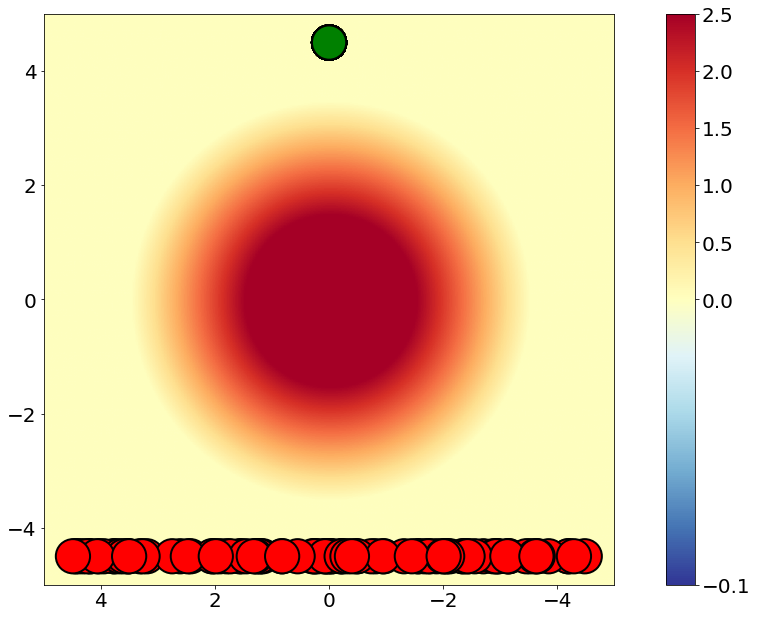

In [24]:
map_1, resolution = read_map("./data/map_1.xml")
starts_map_1, goals_map_1 = read_tasks("./data/tasks_map_1.xml")
robot_size = 0.3
draw_all_tasks(map_1, resolution, starts_map_1, goals_map_1, robot_size)
# plt.savefig('map_1_pos.png', bbox_inches='tight', dpi=300)

### Map 2

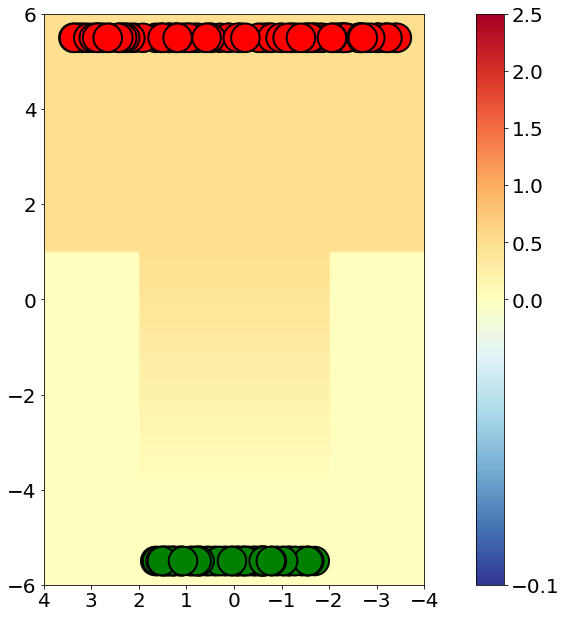

In [25]:
map_2, resolution = read_map("./data/map_2.xml")
starts_map_2, goals_map_2 = read_tasks("./data/tasks_map_2.xml")
robot_size = 0.3
draw_all_tasks(map_2, resolution, starts_map_2, goals_map_2, robot_size)
# plt.savefig('map_2_pos.png', bbox_inches='tight', dpi=300)

### Map 3

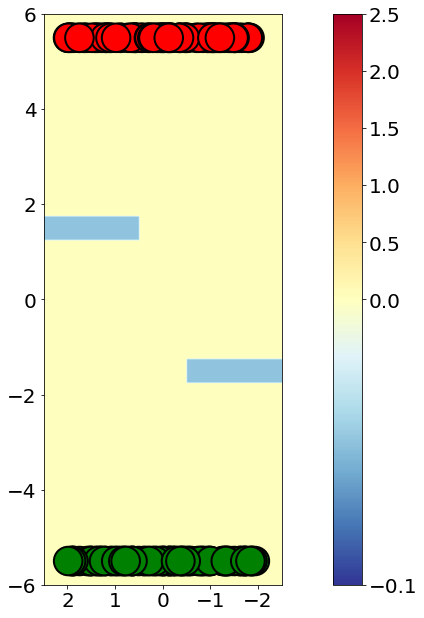

In [26]:
map_3, resolution = read_map("./data/map_3.xml")
starts_map_3, goals_map_3 = read_tasks("./data/tasks_map_3.xml")
robot_size = 0.3
draw_all_tasks(map_3, resolution, starts_map_3, goals_map_3, robot_size)
# plt.savefig('map_3_pos.png', bbox_inches='tight', dpi=300)

## Чтение результатов

### Визуализация

In [27]:
def draw_result(result_dir, result_prefix, task_number, height_map, resolution, starts, goals, robot_size):

    fig, ax = draw_map_2d(height_map, resolution)
    start = starts[task_number]
    goal = goals[task_number]


    start_circ = plt.Circle((start[1], start[0]), robot_size, facecolor ='g', edgecolor='k', linewidth=2)
    ax.add_patch(start_circ)
    goal_circ = plt.Circle((goal[1], goal[0]), robot_size, facecolor ='r', edgecolor='k', linewidth=2)
    ax.add_patch(goal_circ)
#     plt.plot([start[1], goal[1]], [start[0], goal[0]], color='k')

    xs, ys, yaws, success = read_path_x_y_yaw_s(result_dir + result_prefix + str(task_number) + ".txt")
    print(success)

    path = convert_path_to_x_y_z(xs, ys, resolution, height_map)


    plt.plot(path[:, 1], path[:, 0], color='darkgreen')   
    for step in range(len(xs)):
        circ = plt.Circle((ys[step], xs[step]), robot_size, color='seagreen', alpha=0.1)
        ax.add_patch(circ)
    return fig, ax

        
def draw_result_on_im(fig, ax, result_dir, result_prefix, task_number, height_map, resolution, starts, goals, robot_size):

    start = starts[task_number]
    goal = goals[task_number]


#     start_circ = plt.Circle((start[1], start[0]), robot_size, facecolor ='g', edgecolor='k', linewidth=2)
#     ax.add_patch(start_circ)
#     goal_circ = plt.Circle((goal[1], goal[0]), robot_size, facecolor ='r', edgecolor='k', linewidth=2)
#     ax.add_patch(goal_circ)
#     plt.plot([start[1], goal[1]], [start[0], goal[0]], color='c')

    xs, ys, yaws, success = read_path_x_y_yaw_s(result_dir + result_prefix + str(task_number) + ".txt")
    print(success)

    path = convert_path_to_x_y_z(xs, ys, resolution, height_map)


    plt.plot(path[:, 1], path[:, 0], color='darkred')   
    for step in range(len(xs)):
        circ = plt.Circle((ys[step], xs[step]), robot_size, color='indianred', alpha=0.1)
        ax.add_patch(circ)

True
True


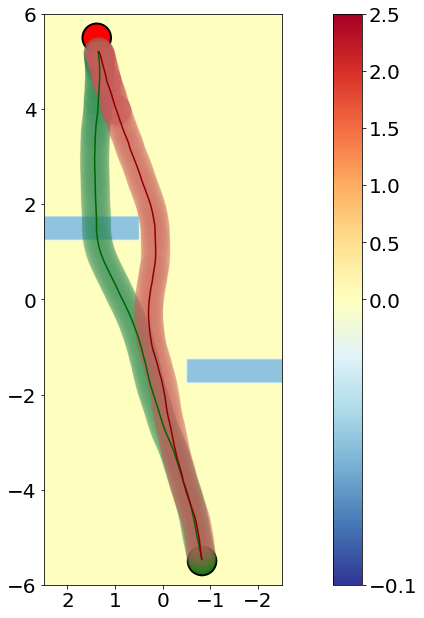

In [28]:
result_dir = "./results/"
result_prefix = "map_3_trav_result_task_"
result_prefix_2 = "map_3_sr_result_task_"
task_number = 9
# print(starts_map_3[0])
# print(goals_map_3[0])


# result_file = result_dir + result_prefix + str(task_number) + ".txt"
# xs, ys, yaws, success = read_path_x_y_yaw_s(result_file)
# path = convert_path_to_x_y_z(xs, ys, resolution, map_1)
# s,r = max_slope_roughness(map_1, path, 0.3, resolution)
# print(s, r)

fig, ax, = draw_result(result_dir, result_prefix, task_number, map_3, resolution, starts_map_3, goals_map_3, 0.3)
draw_result_on_im(fig, ax, result_dir, result_prefix_2, task_number, map_3, resolution, starts_map_3, goals_map_3, 0.3)

# plt.savefig('map_3_traj.png', bbox_inches='tight', dpi=250)

True
True


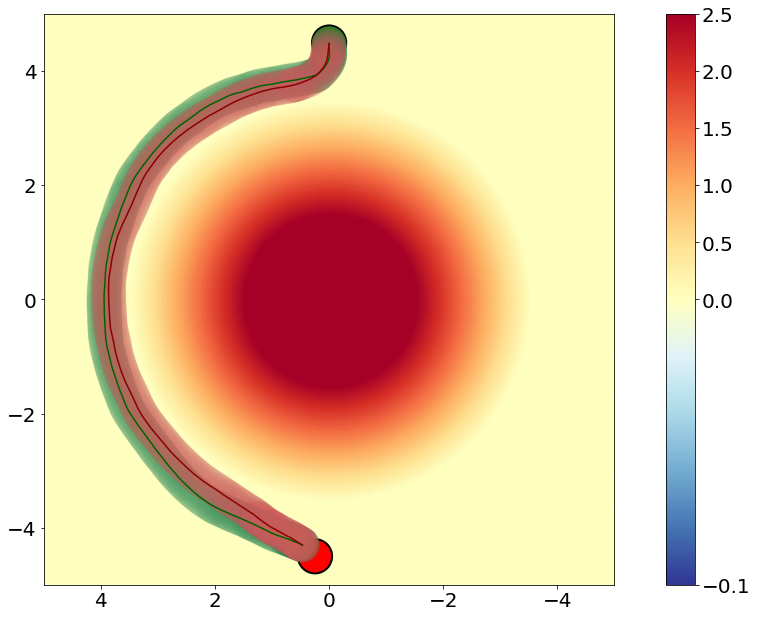

In [29]:


result_dir = "./results/"
result_prefix = "map_1_trav_result_task_"
result_prefix_2 = "map_1_sr_result_task_"
task_number = 11
# print(starts_map_3[0])
# print(goals_map_3[0])


# result_file = result_dir + result_prefix + str(task_number) + ".txt"
# xs, ys, yaws, success = read_path_x_y_yaw_s(result_file)
# path = convert_path_to_x_y_z(xs, ys, resolution, map_1)
# s,r = max_slope_roughness(map_1, path, 0.3, resolution)
# print(s, r)

fig, ax, = draw_result(result_dir, result_prefix, task_number, map_1, resolution, starts_map_1, goals_map_1, 0.3)
draw_result_on_im(fig, ax, result_dir, result_prefix_2, task_number, map_1, resolution, starts_map_1, goals_map_1, 0.3)

# plt.savefig('map_1_traj.png', bbox_inches='tight', dpi=250)

True
True


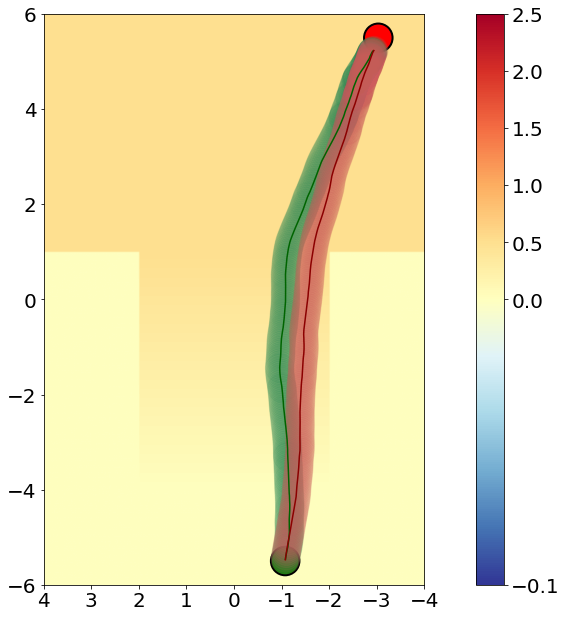

In [30]:


result_dir = "./results/"
result_prefix = "map_2_trav_result_task_"
result_prefix_2 = "map_2_sr_result_task_"
task_number = 61
# print(starts_map_3[0])
# print(goals_map_3[0])

fig, ax, = draw_result(result_dir, result_prefix, task_number, map_2, resolution, starts_map_2, goals_map_2, 0.3)
draw_result_on_im(fig, ax, result_dir, result_prefix_2, task_number, map_2, resolution, starts_map_2, goals_map_2, 0.3)


# plt.savefig('map_2_traj.png', bbox_inches='tight', dpi=250)

### Results analysis  

In [31]:
number_of_results = 6
number_of_tasks = 100

success_table = np.zeros((number_of_tasks, number_of_results))
len_table = np.zeros((number_of_tasks, number_of_results))
sim_time_table = np.zeros((number_of_tasks, number_of_results))
dz_table = np.zeros((number_of_tasks, number_of_results))
slp_table = np.zeros((number_of_tasks, number_of_results))
rgh_table = np.zeros((number_of_tasks, number_of_results))

dt = 0.1



len_table_2 = np.zeros((number_of_tasks, number_of_results))
sim_time_table_2  = np.zeros((number_of_tasks, number_of_results))
dz_table_2  = np.zeros((number_of_tasks, number_of_results))
slp_table_2  = np.zeros((number_of_tasks, number_of_results))
rgh_table_2  = np.zeros((number_of_tasks, number_of_results))


def compute_metrics(result_dir, result_prefix, number_of_tasks, dt, height_map, resolution, size, result_id):
    for i in range(number_of_tasks):
        result_file = result_dir + result_prefix + str(i) + ".txt"
        xs, ys, yaws, success = read_path_x_y_yaw_s(result_file)
        
        success_table[i, result_id] = int(success)
        
        path = convert_path_to_x_y_z(xs, ys, resolution, height_map)
        len_table[i, result_id] = path_len(path)
        sim_time_table[i, result_id] = sim_time(path, dt)
#         dz_table[i, result_id] = max_height_diff(path)
#         s,r = max_slope_roughness(height_map, path, size, resolution)
#         slp_table[i, result_id] = s
#         rgh_table[i, result_id] = r

In [32]:
result_dir = "./results/"
result_prefix = "map_1_trav_result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, map_1, resolution, 0.3, 0)

In [33]:
result_dir = "./results/"
result_prefix = "map_2_trav_result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, map_2, resolution, 0.3, 1)

In [34]:
result_dir = "./results/"
result_prefix = "map_3_trav_result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, map_3, resolution, 0.3, 2)

In [35]:
result_dir = "./results/"
result_prefix = "map_1_sr_result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, map_1, resolution, 0.3, 3)

In [36]:
result_dir = "./results/"
result_prefix = "map_2_sr_result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, map_2, resolution, 0.3, 4)

In [37]:
result_dir = "./results/"
result_prefix = "map_3_sr_result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, map_3, resolution, 0.3, 5)

In [38]:
names = {0 : "map_1_trav",
         1 : "map_2_trav",
         2 : "map_3_trav",
         3 : "map_1_sr",
         4 : "map_2_sr",
         5 : "map_3_sr",}
print("Success rate")
for i in range(number_of_results):
    print(names[i], ":", np.sum(success_table[:, i]), "%")
    
len_table_2 = len_table.copy()
sim_time_table_2 = sim_time_table.copy()
dz_table_2 = dz_table.copy()
slp_table_2 = slp_table.copy()
rgh_table_2 = rgh_table.copy()

Success rate
map_1_trav : 100.0 %
map_2_trav : 100.0 %
map_3_trav : 100.0 %
map_1_sr : 100.0 %
map_2_sr : 98.0 %
map_3_sr : 98.0 %


In [39]:
common_count = 0
sum_len = np.zeros(2)
sum_sim_time = np.zeros(2)
sum_dz = np.zeros(2)
sum_slp = np.zeros(2)
sum_rgh = np.zeros(2)

first, second = 0, 3

for i in range(number_of_tasks):
    if success_table[i, first] == 1 and success_table[i, second] == 1:
        common_count += 1
        sum_len += len_table[i, [first, second]]
        sum_sim_time += sim_time_table[i, [first, second]]
        sum_dz += dz_table[i, [first, second]]
        sum_slp += slp_table[i, [first, second]]
        sum_rgh += rgh_table[i, [first, second]]

    else:
        len_table_2[i, [first, second]] = 0
        sim_time_table_2[i, [first, second]] = 0
        dz_table_2[i, [first, second]] = 0
        slp_table_2[i, [first, second]] = 0
        rgh_table_2[i, [first, second]] = 0
        
print("Map 1")
print("Algs:\t\t", names[first],", ", names[second])
print("Path length:\t", sum_len / common_count)
print("Sim time:\t", sum_sim_time / common_count)

print()
print("Common tasks:", common_count)

Map 1
Algs:		 map_1_trav ,  map_1_sr
Path length:	 [11.36389294 11.18216236]
Sim time:	 [30.517 29.981]

Common tasks: 100


In [40]:
common_count = 0
sum_len = np.zeros(2)
sum_sim_time = np.zeros(2)
sum_dz = np.zeros(2)
sum_slp = np.zeros(2)
sum_rgh = np.zeros(2)

first, second = 1, 4

for i in range(number_of_tasks):
    if success_table[i, first] == 1 and success_table[i, second] == 1:
        common_count += 1
        sum_len += len_table[i, [first, second]]
        sum_sim_time += sim_time_table[i, [first, second]]
        sum_dz += dz_table[i, [first, second]]
        sum_slp += slp_table[i, [first, second]]
        sum_rgh += rgh_table[i, [first, second]]
    else:
        len_table_2[i, [first, second]] = 0
        sim_time_table_2[i, [first, second]] = 0
        dz_table_2[i, [first, second]] = 0
        slp_table_2[i, [first, second]] = 0
        rgh_table_2[i, [first, second]] = 0
        
        
print("Map 1")
print("Algs:\t\t", names[first],", ", names[second])
print("Path length:\t", sum_len / common_count)
print("Sim time:\t", sum_sim_time / common_count)

print()
print("Common tasks:", common_count)

Map 1
Algs:		 map_2_trav ,  map_2_sr
Path length:	 [11.01907825 10.98543775]
Sim time:	 [28.51632653 28.05306122]

Common tasks: 98


In [41]:
common_count = 0
sum_len = np.zeros(2)
sum_sim_time = np.zeros(2)
sum_dz = np.zeros(2)
sum_slp = np.zeros(2)
sum_rgh = np.zeros(2)

first, second = 2, 5

for i in range(number_of_tasks):
    if success_table[i, first] == 1 and success_table[i, second] == 1:
        common_count += 1
        sum_len += len_table[i, [first, second]]
        sum_sim_time += sim_time_table[i, [first, second]]
        sum_dz += dz_table[i, [first, second]]
        sum_slp += slp_table[i, [first, second]]
        sum_rgh += rgh_table[i, [first, second]]

    else:
        len_table_2[i, [first, second]] = 0
        sim_time_table_2[i, [first, second]] = 0
        dz_table_2[i, [first, second]] = 0
        slp_table_2[i, [first, second]] = 0
        rgh_table_2[i, [first, second]] = 0
         
print("Map 1")
print("Algs:\t\t", names[first],", ", names[second])
print("Path length:\t", sum_len / common_count)
print("Sim time:\t", sum_sim_time / common_count)

print()
print("Common tasks:", common_count)

Map 1
Algs:		 map_3_trav ,  map_3_sr
Path length:	 [10.9221085  11.26196784]
Sim time:	 [28.37755102 31.49489796]

Common tasks: 98
